In [1]:
import pandas as pd
import src.prepare_dataframe as df_prep
import src.make_plots as m_plot
import src.parse_news as PN
import src.get_data as get_data
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

# Load headline from database

In [2]:
headlines = get_data.loadHeadlines()

In [3]:
data, compound_data = df_prep.averageSintimentEveryDay(headlines)

In [4]:
data.index = data.date
data = data[['neg', 'neu', 'pos']]

compound_data.index = compound_data.date
compound_data = compound_data[['neg', 'neu', 'pos']]

# plot 

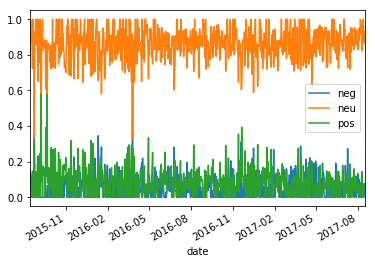

In [5]:
data.plot()

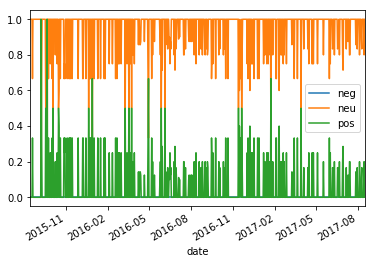

In [6]:
compound_data.plot()

# bin trend

In [7]:
stock_data = get_data.get_data_frame()
stock_data.date  =pd.to_datetime( stock_data.date)
stock_data.index = stock_data.date
stock_close_bin = pd.DataFrame(data = ((stock_data.close \
                                        - stock_data.close.shift(1)) > 0).astype('int'))

all_data = pd.concat([stock_close_bin, stock_data.close, data], axis = 1)
all_data = all_data.dropna()

# build NN


In [8]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Dense
from keras.layers import LSTM


Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [9]:
def build_model(input_shape):

    d = 0.2
    model = Sequential()
    
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(128, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="normal",activation='relu'))        
    model.add(Dense(1,kernel_initializer="normal",activation='linear'))
    
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    
    return model

In [17]:
import src.compute_income as ci
from sklearn.preprocessing import MinMaxScaler
import src.load_data as load
from keras.callbacks import History 
import time
from keras.models import Sequential, load_model, save_model
import src.make_plots as MP
from sklearn import metrics
from keras import backend as K 

import numpy as np

WINDOW = 22

In [22]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

import seaborn as sns
from pylab import rcParams
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8


init_notebook_mode(connected=True)

%matplotlib inline

In [26]:
plot = True
plotHictory = True
interactiveGrapth = True
plotForTrain = False
    
all_data.columns = [['close_lbl','close','neg','neu','pos']]
x = pd.DataFrame(all_data[['close','neg','neu','pos']].copy())
y = pd.DataFrame(all_data['close'].copy())

features = ['close','neg','neu','pos']
NUM_FEATURES = x.shape[1]

scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

x[features] = scaler.fit_transform(x)

y['close'] = y_scaler.fit_transform(y.values.reshape(-1,1))
x[['cl_2']] = y

X_train, y_train, X_test, y_test = load.load_data(x, WINDOW, train_size= 0.95,\
                                                  TrainTest = True)
x = x[features] 

model = build_model(input_shape=(WINDOW, NUM_FEATURES))


print('START FIT MODEL...')
history = History()
history= model.fit(X_train, y_train, validation_data=(X_test, y_test),  batch_size=32,\
                   epochs = 300,verbose=0,    callbacks=[history])

today = time.strftime("_%d_%m_%Y")

pathModel = "model_sentiment"  + today +".h5"

save_model(model, pathModel)



START FIT MODEL...


[ 2979.91625977]
Train Score: 39.68 RMSE
Test Score: 618.66 RMSE


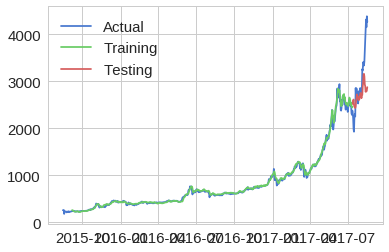

income ACTUAL: 
3403.73312094
income PREDICTED: 
1206.41991133
% TRUE predicted labels for TREND:
0.555555555556


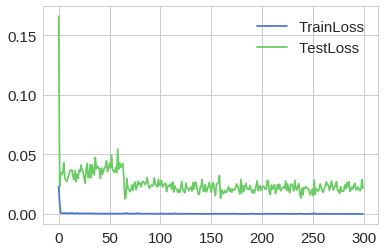

In [27]:
model = load_model(pathModel)

lastbatch = np.array(x[-WINDOW:])
pred = model.predict([lastbatch.reshape(1,WINDOW, NUM_FEATURES)])
pred =  np.array(y_scaler.inverse_transform(pred)) 

prediction = pred.reshape(-1)

print (prediction)

if plot:


    prices, trainPredictPlot, testPredictPlot, testPredict, testY = MP.plot_quality_graph(\
                                                        all_data, model,\
                                                        X_train, X_test, y_train, \
                                                        y_test, y_scaler)

    calc_income = all_data.close[-y_test.shape[0]:]

############################ income ##############################3
    print ('income ACTUAL: ')
    print (ci.calcDOXOD(calc_income, ci.classifyALL(calc_income)    ))
    print ('income PREDICTED: ')
    print (ci.calcDOXOD(calc_income, ci.classifyALL(testPredict.reshape(-1,)))    )   
############################ number TRUE predicted labels for TREND #######
    print ('% TRUE predicted labels for TREND:')
    quality = np.sum([ci.classifyALL(testY.reshape(-1,)) == ci.classifyALL(testPredict.reshape(-1,))])
    print (quality/testPredict.shape[0])

    if interactiveGrapth:
        MP.plot_interactive(x, prices, trainPredictPlot, testPredictPlot)

    if plotHictory:
        MP.plotHictory(history)

    del model
    K.clear_session()